In [143]:
import pandas as pd;
import numpy as np;
import os
import requests
import bs4 as bs
import nltk
import re
import time
import sys
import logging
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
from itertools import cycle;
import json

from gensim.models import word2vec;


from nltk.corpus import words, stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, sent_tokenize, pos_tag
#from gensim import corpora
import spacy
#spacy.load('en')
from spacy.lang.en import English

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KDTree;

import pyLDAvis.gensim
import warnings
import pickle
import gensim
from nltk.corpus import wordnet as wn
from gensim import corpora

import matplotlib.pyplot as plt

from gensim.models import Word2Vec 

%matplotlib inline

warnings.filterwarnings('ignore')

In [24]:
from nltk.corpus import words

In [424]:
### Change these two variables to make the code run
## This one should be the place where the files are stored
folder_name = "/Volumes/disk2/capstone_json/2019/QTR2/"

## This one should be the location you want to save all the picures
picture_save_loc = "/Users/travis/Downloads/"


In [9]:
# folder_name = '/Users/michael/Downloads/cleaned_SEC/'
folder_name = "/Volumes/disk2/capstone_json/2019/QTR2/"
file_names = [f for f in os.listdir(folder_name) if f[-4:] == '10-Q']

In [68]:
stemmer = PorterStemmer()
all_words = set(words.words())

In [73]:
# fn = "amazoncominc_10-Q"
# fn = file_names[1200]

class DecoyStemmer(object):
    '''
    Class which allows for boolean option in clean_words function
    --------
    ATTRIBUTES
    thisis: str
        - returns 'decoy_stemmer'
    --------
    METHODS
    stem:
        inputs
            word (str)
        returns
            word (the same str)
    '''
    def __init__(self):
        self.thisis = 'decoy_stemmer'
    def stem(self, word):
        return word

def clean_words(fn, stem_words=True):
    if stem_words:
        stemmer = PorterStemmer()
    else:
        stemmer = DecoyStemmer()
    jobj = json.load(open(folder_name + fn))
    new_dic = {}
    for k,v in jobj.items():
        if re.search("[^a-z]", k):
            try:
                new_dic[stemmer.stem(re.split("[^a-z]", k)[0])] += v
            except KeyError:
                new_dic[stemmer.stem(re.split("[^a-z]", k)[0])] = v
        else:
            if k in all_words:
                new_dic[stemmer.stem(k)] = v
    try:
        del new_dic['']
        return new_dic
    except KeyError:
        return new_dic

In [74]:
filings_for_kmeans = []
count = 0
for file_name in file_names:
    try:
#         fh = json.load(open(folder_name + file_name))
        fh = clean_words(file_name)
    except json.JSONDecodeError:
        print("Error With: ", file_name)
        continue
    extended_file = " "
    for word, qty in fh.items():
#         if word in all_words:
        for i in range(qty):
            extended_file = extended_file + " " + word
    filings_for_kmeans.append(extended_file)

Error With:  americanexpressco_10-Q


In [75]:
len(filings_for_kmeans)

3738

In [78]:
tfidf = TfidfVectorizer(
    stop_words='english',
    min_df=.02,
    max_df=.15)
tfidf_model = tfidf.fit_transform(filings_for_kmeans)

#tfidf_model.shape

# type(tfidf_model)

In [79]:
len(file_names)

3739

In [82]:
tfidf_model.shape

(3738, 1113)

# Elbow Method

In [ ]:
from scipy.spatial.distance import cdist

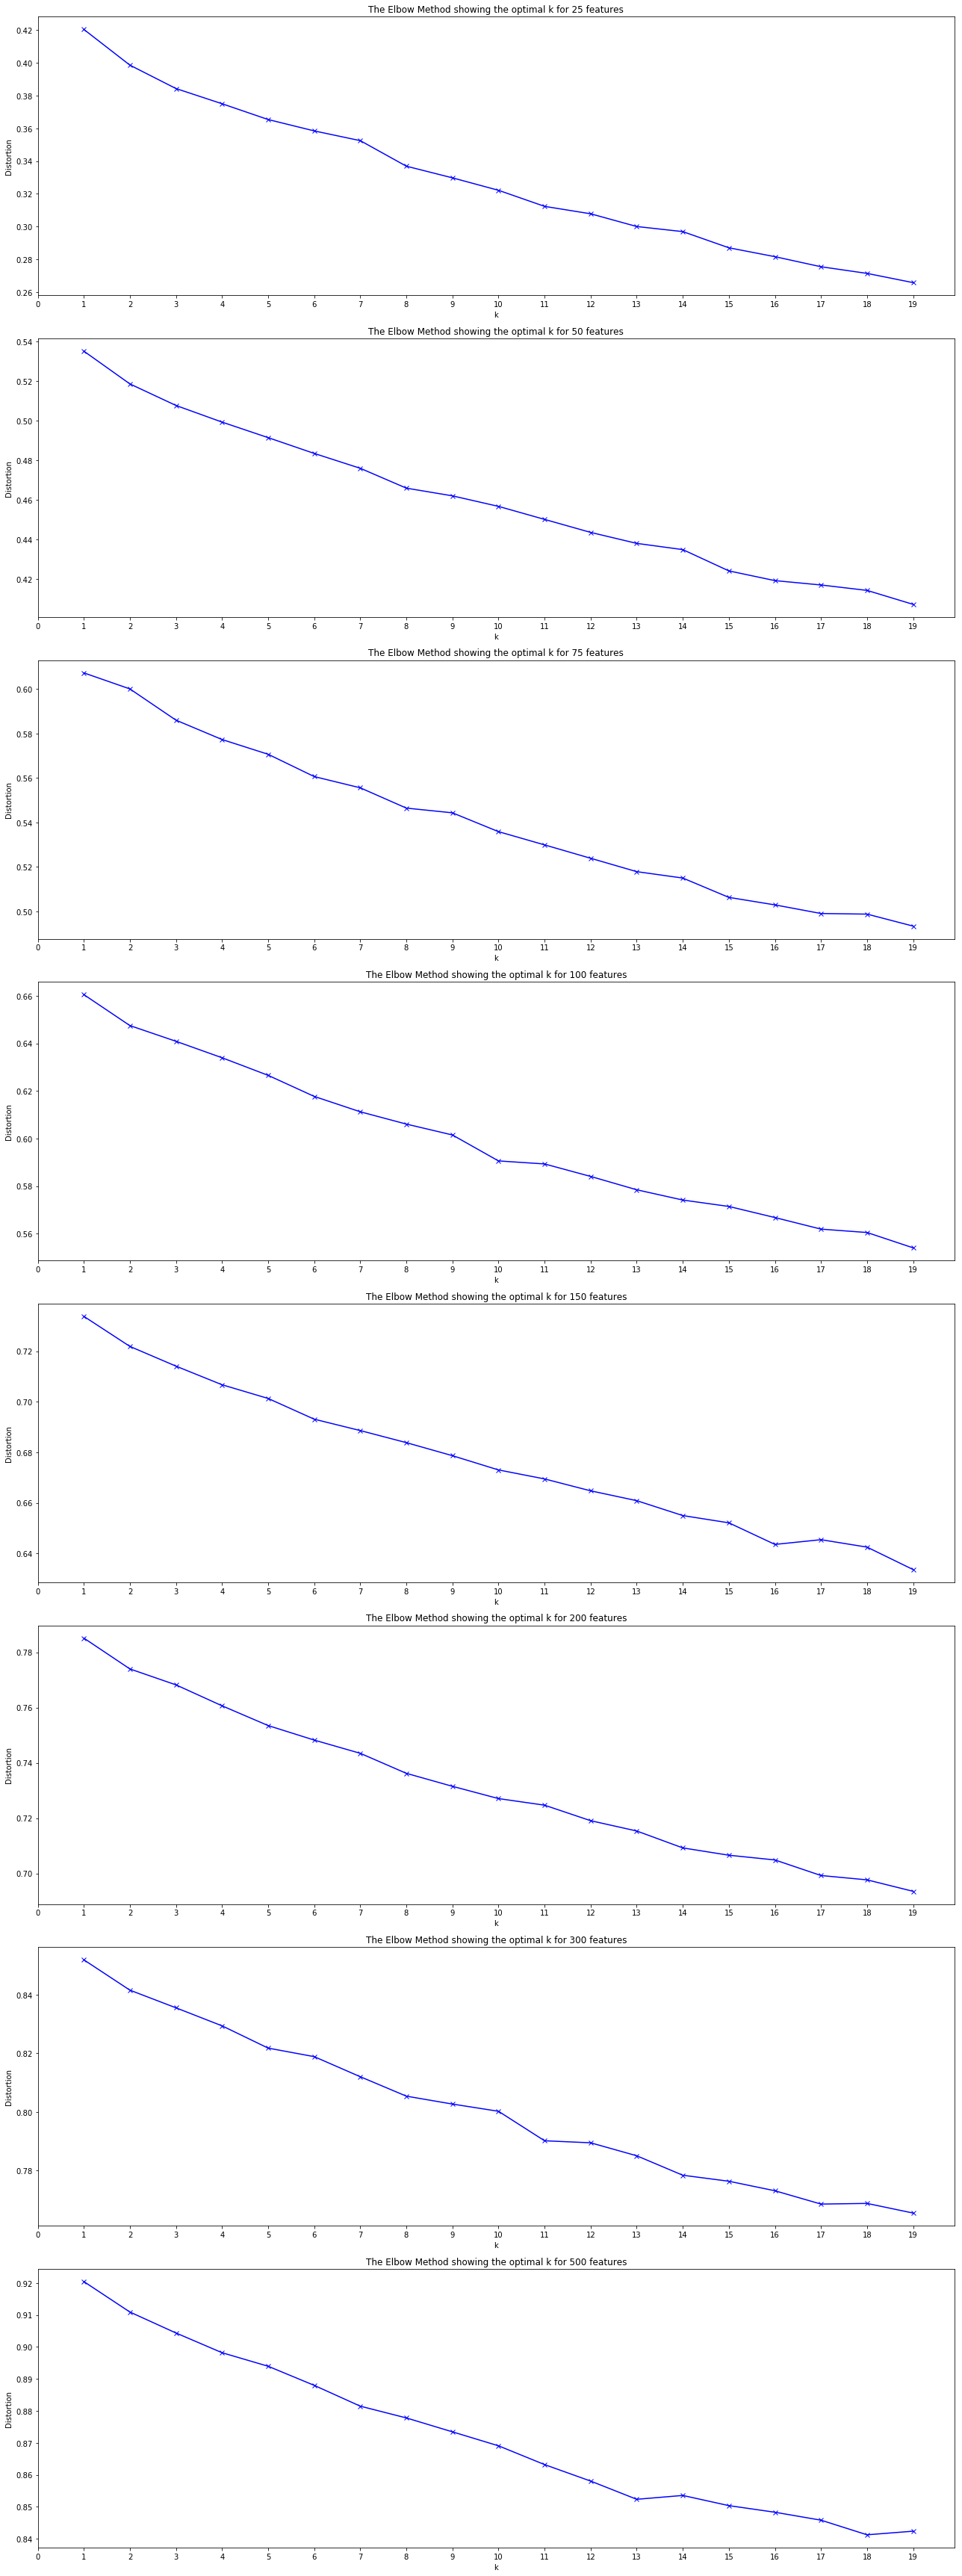

In [122]:
### Checking dimensionality reduction through PCA

colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# X = tfidf_model.toarray()
# X = PCA(n_components=250).fit_transform(tfidf_model.todense())

k_max = 20


fig, ax = plt.subplots(8, 1, figsize=(18, 6 * 8))

## k means determine k
for i,comps in enumerate([25, 50, 75, 100, 150, 200, 300, 500]):
    X = PCA(n_components=comps).fit_transform(tfidf_model.todense())
    distortions = []
    K = range(1, k_max)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(
            sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0])

    # Plot the elbow
    ax[i].plot(K, distortions, 'bx-')
    ax[i].set_xlabel('k')
    ax[i].set_xticks(range(k_max))
    ax[i].set_ylabel('Distortion')
    ax[i].set_title('The Elbow Method showing the optimal k for {} features'.format(comps))
    
plt.tight_layout()
# plt.show()

In [123]:
fig.savefig(picture_save_loc + "elbow_method_compare")

In [125]:
"{:.3f}".format(.9999999)

'1.000'

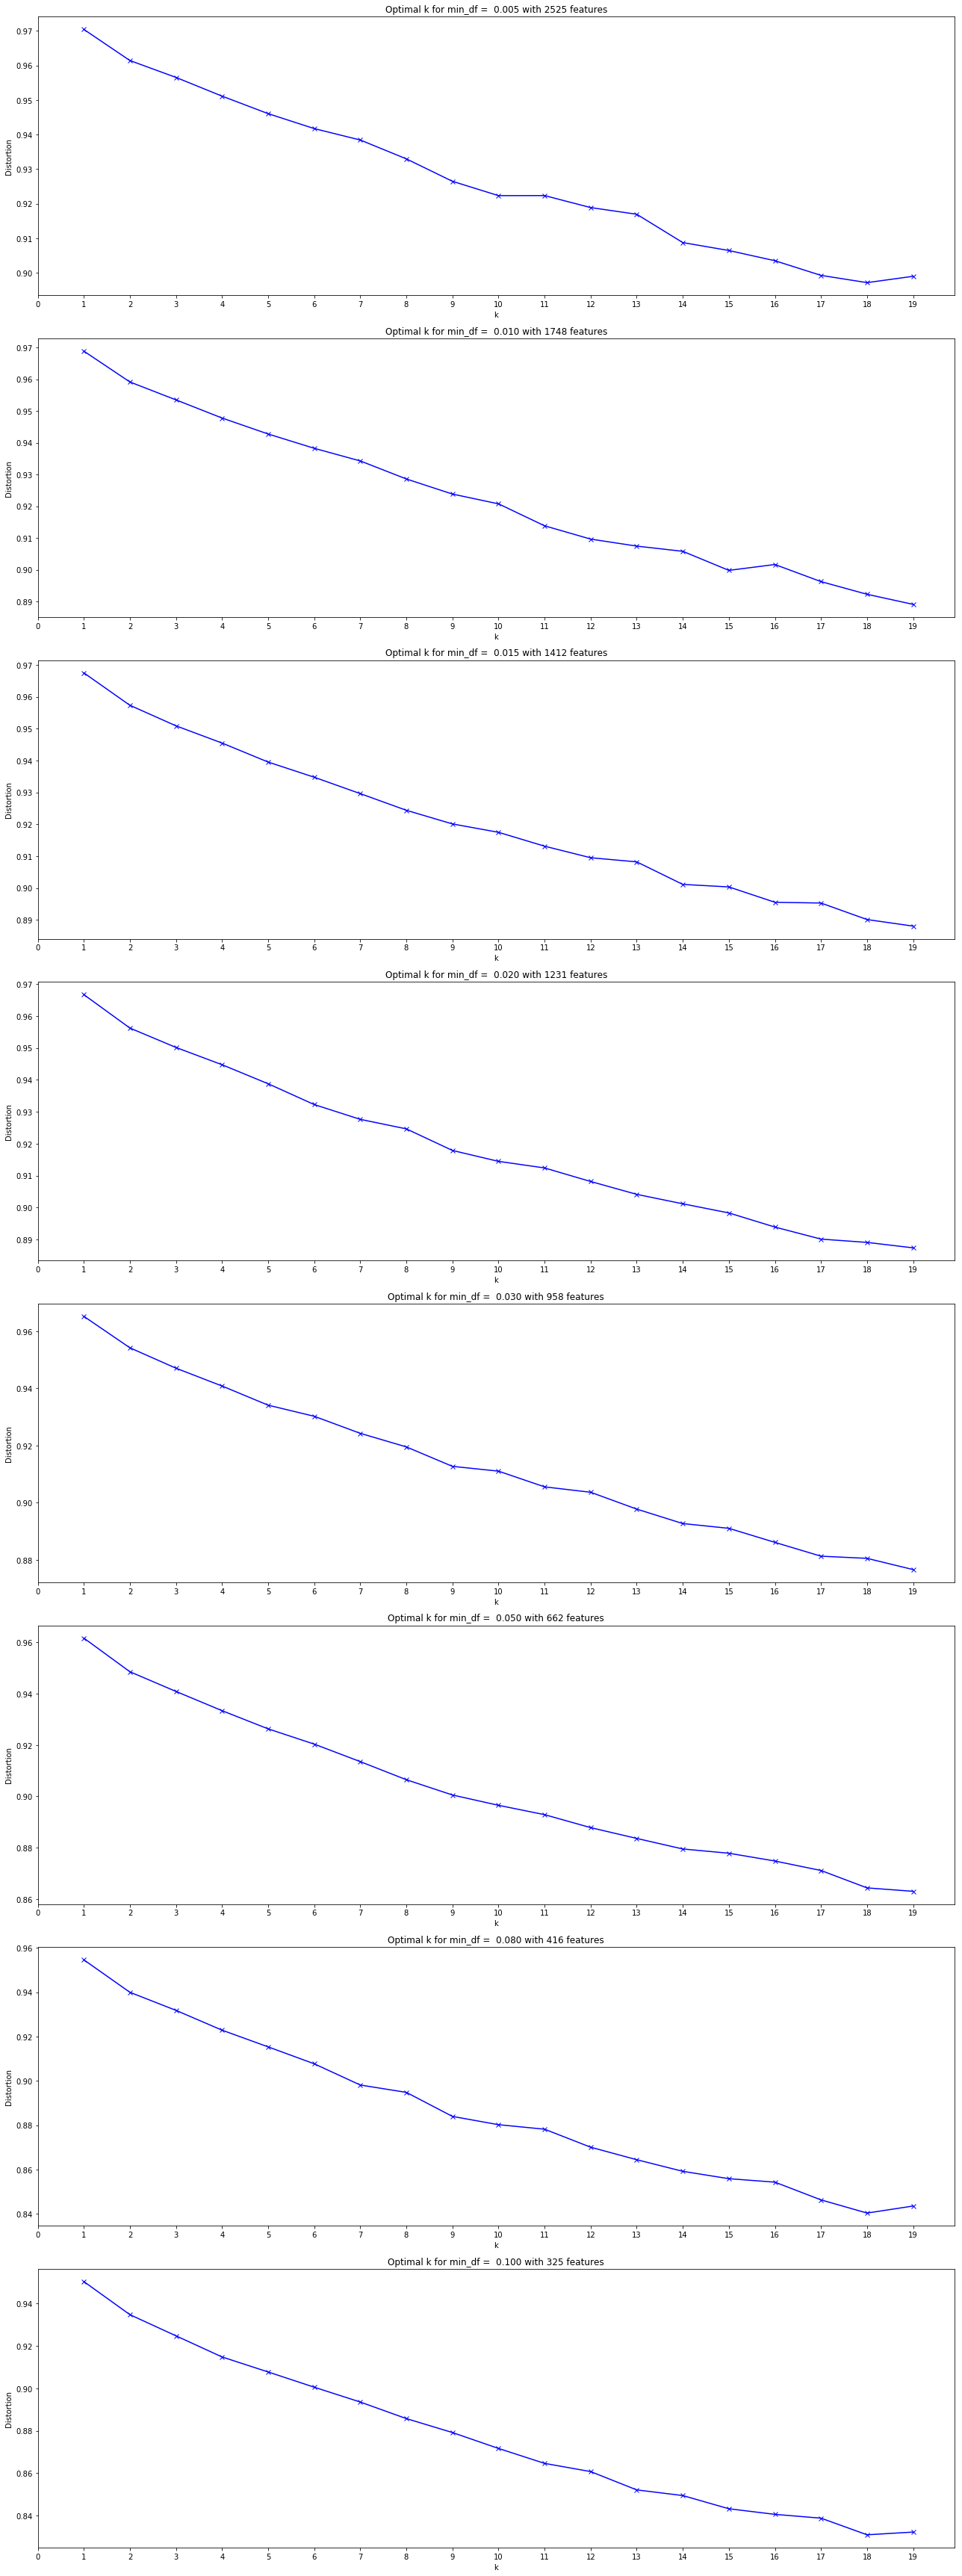

In [126]:
### Checking dimensionality reduction through TFIDF optimization

colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']


tfidf_model = TfidfVectorizer(
    stop_words='english',
    min_df=.02,
    max_df=.15).fit_transform(filings_for_kmeans)
# X = tfidf_model.toarray()
# X = PCA(n_components=250).fit_transform(tfidf_model.todense())

k_max = 20
max_df = .20


fig, ax = plt.subplots(8, 1, figsize=(18, 6 * 8))

## k means determine k
for i,min_df in enumerate([.005, .01, .015, .02, .03, .05, .08, .1]):
    tfidf_model = TfidfVectorizer(
        stop_words='english',
        min_df= min_df,
        max_df= max_df).fit_transform(filings_for_kmeans)
    X = tfidf_model.toarray()
    num_features = X.shape[1]
    distortions = []
    K = range(1, k_max)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(
            sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0])
    # Plot the elbow
    ax[i].plot(K, distortions, 'bx-')
    ax[i].set_xlabel('k')
    ax[i].set_xticks(range(k_max))
    ax[i].set_ylabel('Distortion')
    ax[i].set_title('Optimal k for min_df =  {:.3f} with {} features'\
                    .format(min_df, num_features))
plt.tight_layout()
# plt.show()

In [127]:
fig.savefig(picture_save_loc + min_df_compare")

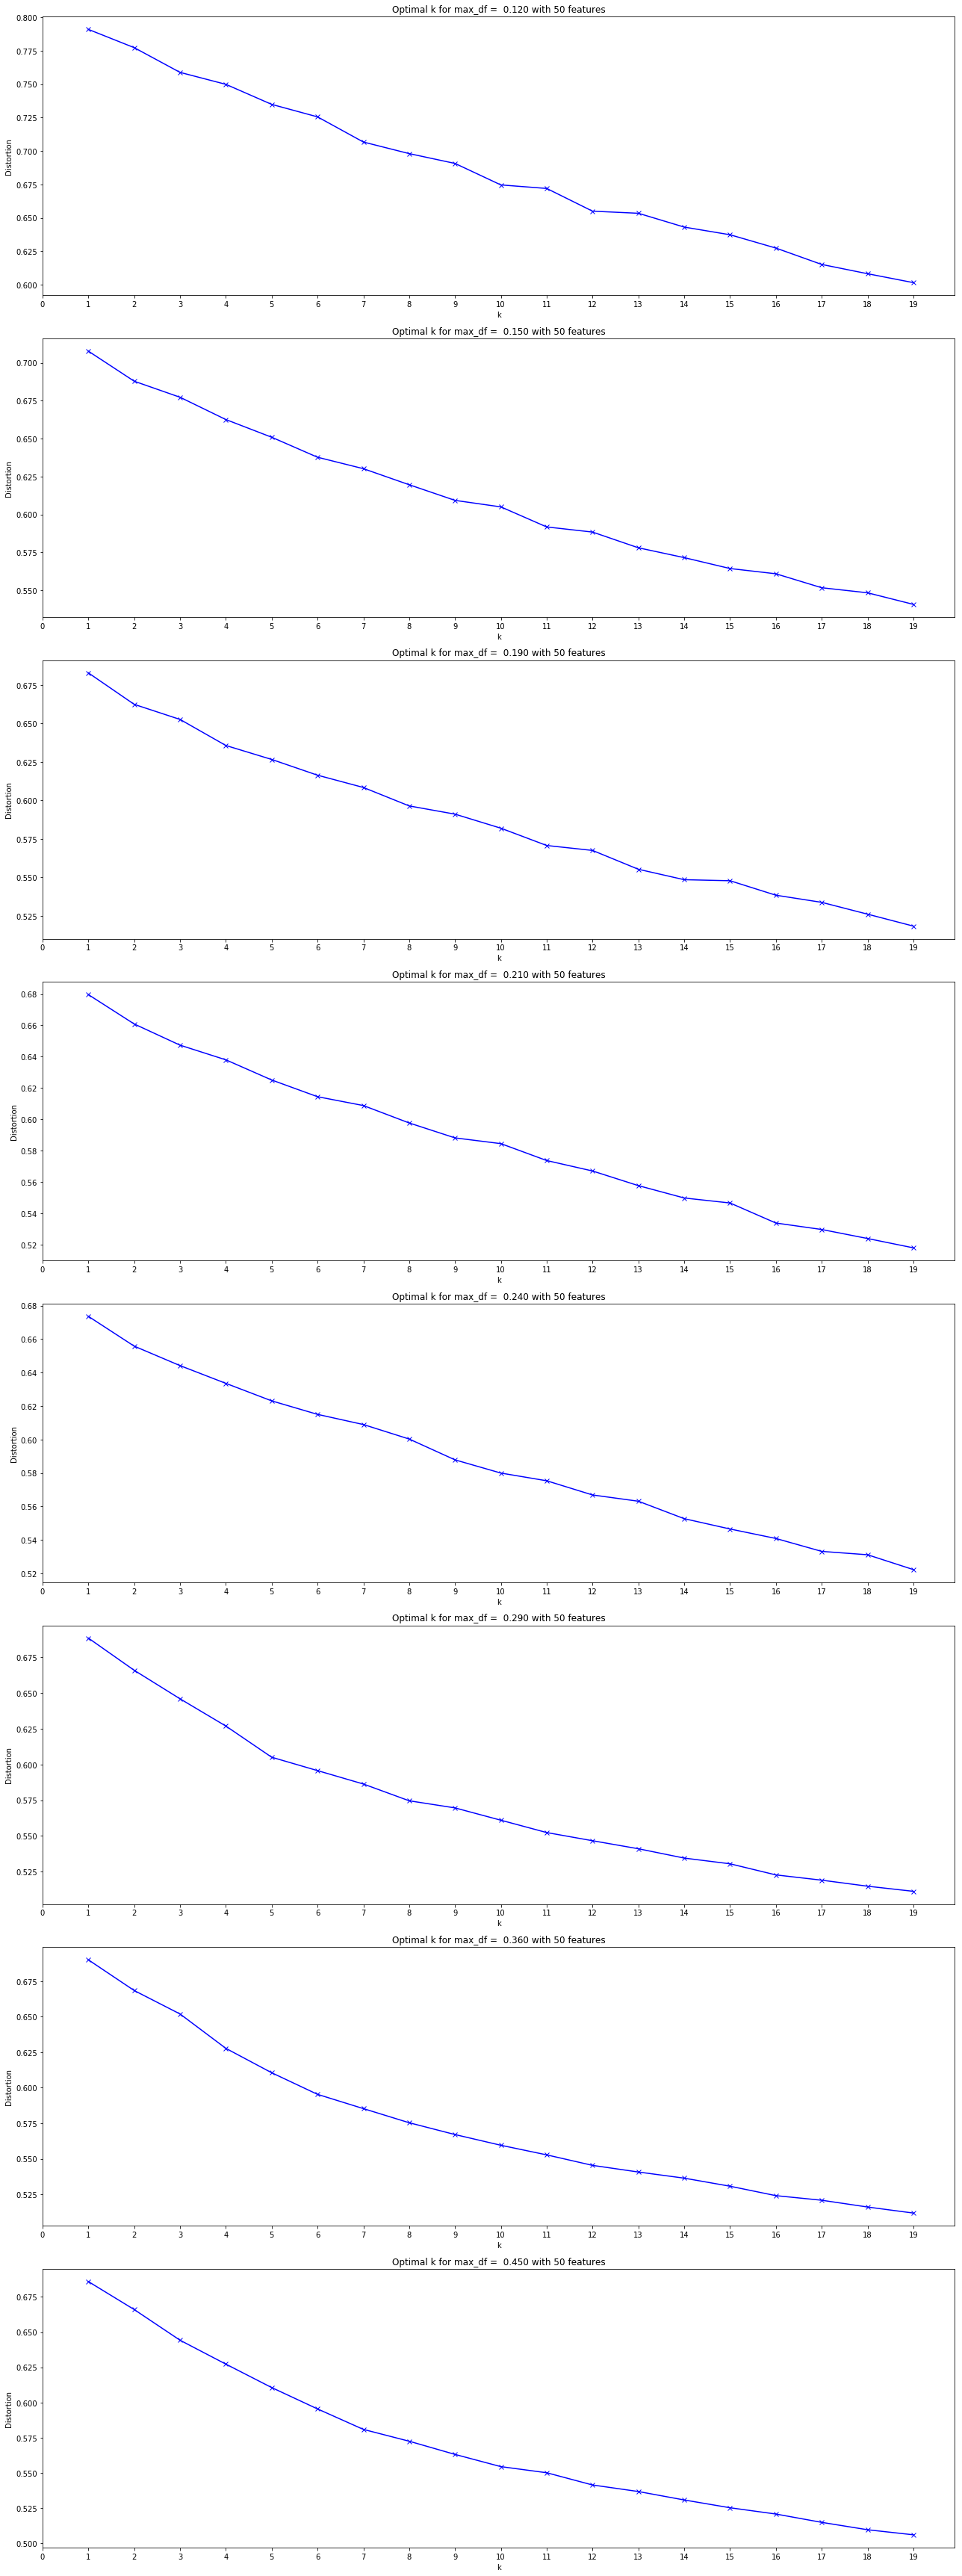

In [268]:
### Checking dimensionality reduction through TFIDF optimization (now with MAX_df)

colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']


tfidf_model = TfidfVectorizer(
    stop_words='english',
    min_df=.08,
    max_df=.15).fit_transform(filings_for_kmeans)
# X = tfidf_model.toarray()
# X = PCA(n_components=250).fit_transform(tfidf_model.todense())

k_max = 20
max_df = .20


fig, ax = plt.subplots(8, 1, figsize=(18, 6 * 8))

## k means determine k
for i,max_df in enumerate([.12, .15, .19, .21, .24, .29, .36, .45]):
    tfidf_model = TfidfVectorizer(
        stop_words='english',
        min_df= min_df,
        max_df= max_df).fit_transform(filings_for_kmeans)
    X = PCA(n_components=50).fit_transform(tfidf_model.todense())
    num_features = X.shape[1]
    distortions = []
    K = range(1, k_max)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(
            sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0])
    # Plot the elbow
    ax[i].plot(K, distortions, 'bx-')
    ax[i].set_xlabel('k')
    ax[i].set_xticks(range(k_max))
    ax[i].set_ylabel('Distortion')
    ax[i].set_title('Optimal k for max_df =  {:.3f} with {} features'\
                    .format(max_df, num_features))
plt.tight_layout()

In [270]:
tfidf_model = TfidfVectorizer(
    stop_words='english',
    min_df=  .08,
    max_df= .29).fit_transform(filings_for_kmeans)

X = PCA(n_components=50).fit_transform(tfidf_model.todense())

# Plotting KMeans

In [271]:
kmeans4 = KMeans(n_clusters=4).fit_predict(tfidf_model)
PCA4 = PCA(n_components=2).fit_transform(tfidf_model.todense())

kmeans2 = KMeans(n_clusters=2).fit_predict(tfidf_model)
PCA2 = PCA(n_components=2).fit_transform(tfidf_model.todense())

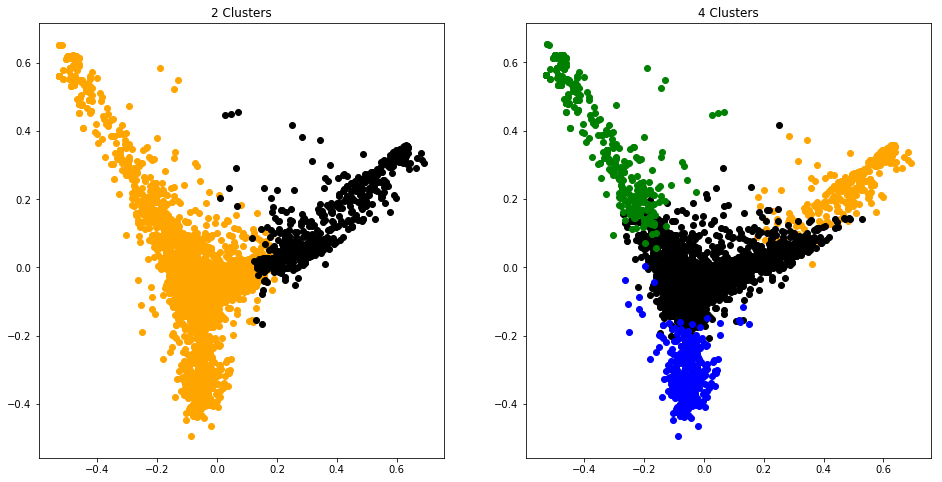

In [272]:
colors = ['orange', 'black', 'green', 'blue', 'yellow', 'red', 'purple', 'light_blue']

fig, ax = plt.subplots(1,2, figsize=(16,8))
for cls, col in enumerate(colors[:4]):
    cls2 = PCA2[kmeans2 == cls]
    cls4 = PCA4[kmeans4 == cls]
    ax[0].scatter(cls2[:,0], cls2[:,1], color=col)
    ax[1].scatter(cls4[:,0], cls4[:,1], color=col)
ax[0].set_title("2 Clusters")
ax[1].set_title("4 Clusters")

In [ ]:
fig.savefig(picture_save_loc + ""

In [273]:
kmeans6 = KMeans(n_clusters=6).fit_predict(tfidf_model)
PCAi = PCA(n_components=2).fit_transform(tfidf_model.todense())
# PCA6 = PCA(n_components=2).fit_transform(tfidf_model.todense())

kmeans8 = KMeans(n_clusters=8).fit_predict(tfidf_model)
# PCA8 = PCA(n_components=2).fit_transform(tfidf_model.todense())

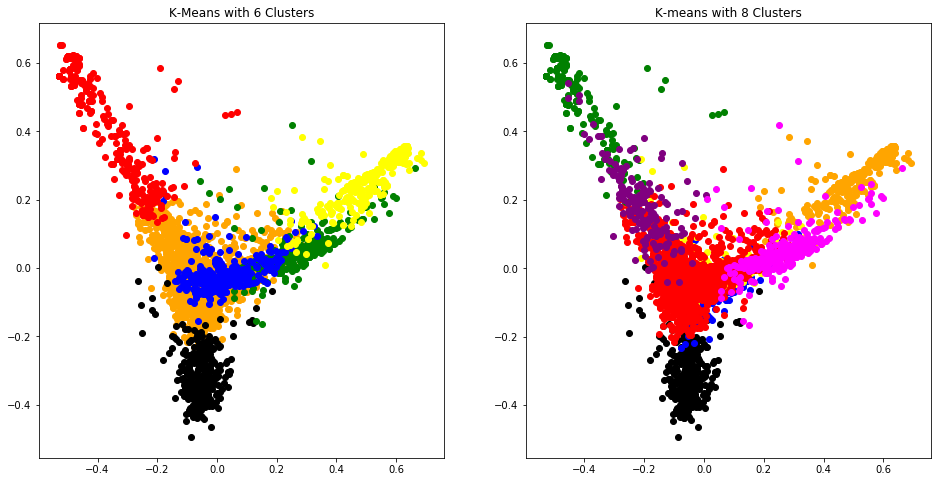

In [288]:
colors = ['orange', 'black', 'green', 'blue', 'yellow', 'red', 'purple', 'magenta']

fig, ax = plt.subplots(1,2, figsize=(16,8))
for cls, col in enumerate(colors[:16]):
    cls6 = PCAi[kmeans6 == cls]
    cls8 = PCAi[kmeans8 == cls]
    ax[0].scatter(cls6[:,0], cls6[:,1], color=col)
    ax[1].scatter(cls8[:,0], cls8[:,1], color=col)
ax[0].set_title("K-Means with 6 Clusters")
ax[1].set_title("K-means with 8 Clusters")

In [290]:
fig.savefig("/Users/travis/Downloads/6_8_clusters_kmns_mindf008_maxdf290_50feat")

In [285]:
kmeans12 = KMeans(n_clusters=12).fit_predict(tfidf_model)
PCAi = PCA(n_components=2).fit_transform(tfidf_model.todense())

kmeans18 = KMeans(n_clusters=18).fit_predict(tfidf_model)
# PCA18 = PCA(n_components=2).fit_transform(tfidf_model.todense())

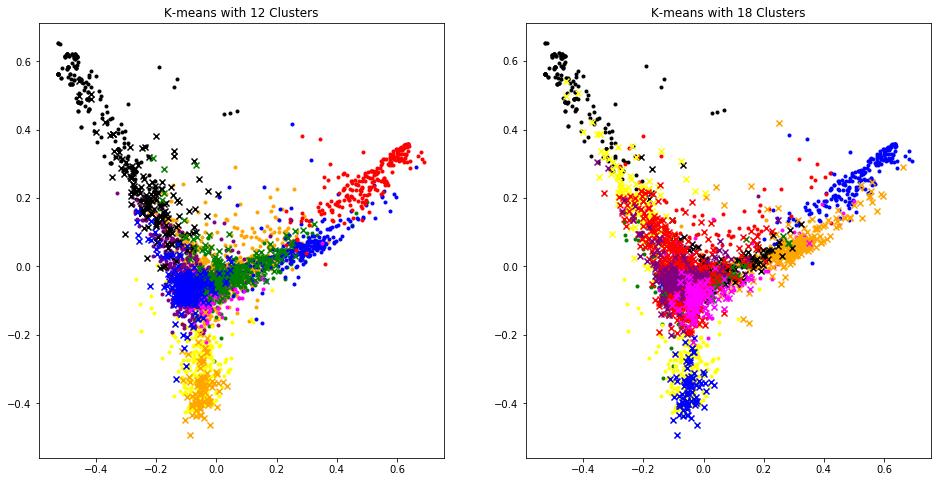

In [286]:
colors = ['orange', 'black', 'green', 'blue', 'yellow', 'red', 'purple', 'magenta',
         'orange', 'black', 'green', 'blue', 'yellow', 'red', 'purple', 'magenta']

fig, ax = plt.subplots(1,2, figsize=(16,8))
count = 0
for cls, col in enumerate(colors[:16]):
    if count < 8:
        marker_ = "."
    else:
        marker_ = "x"
        
    cls12 = PCAi[kmeans12 == cls]
    cls16 = PCAi[kmeans18 == cls]
    ax[0].scatter(cls12[:,0], cls12[:,1], color=col, marker = marker_)
    ax[1].scatter(cls16[:,0], cls16[:,1], color=col, marker = marker_)
    count = count + 1
ax[0].set_title("K-means with 12 Clusters")
ax[1].set_title("K-means with 18 Clusters")

In [287]:
# fig.savefig('/Users/michael/Downloads/12_clusters')
fig.savefig("/Users/travis/Downloads/12_18_clusters_kmns_mindf008_maxdf290_50feat")

# Agglomerative Clustering

In [278]:
from sklearn.cluster import AgglomerativeClustering

In [279]:
# X = tfidf_model.toarray()

In [280]:
hcluster6 = AgglomerativeClustering(n_clusters=6).fit_predict(X)
hcluster8 = AgglomerativeClustering(n_clusters=8).fit_predict(X)
hcluster12 = AgglomerativeClustering(n_clusters=12).fit_predict(X)
hcluster18 = AgglomerativeClustering(n_clusters=18).fit_predict(X)

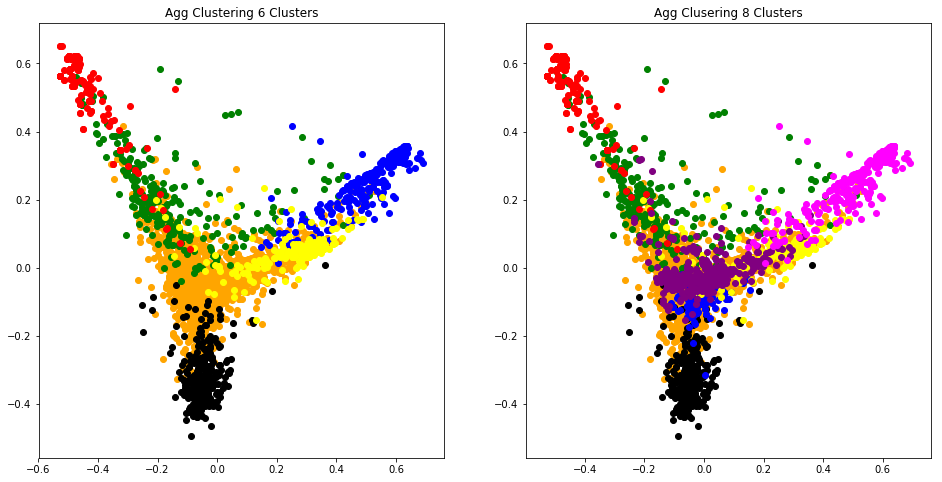

In [281]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
for cls, col in enumerate(colors[:16]):
    cls6 = PCAi[hcluster6 == cls]
    cls8 = PCAi[hcluster8 == cls]
    ax[0].scatter(cls6[:,0], cls6[:,1], color=col)
    ax[1].scatter(cls8[:,0], cls8[:,1], color=col)
ax[0].set_title("Agg Clustering 6 Clusters")
ax[1].set_title("Agg Clusering 8 Clusters")

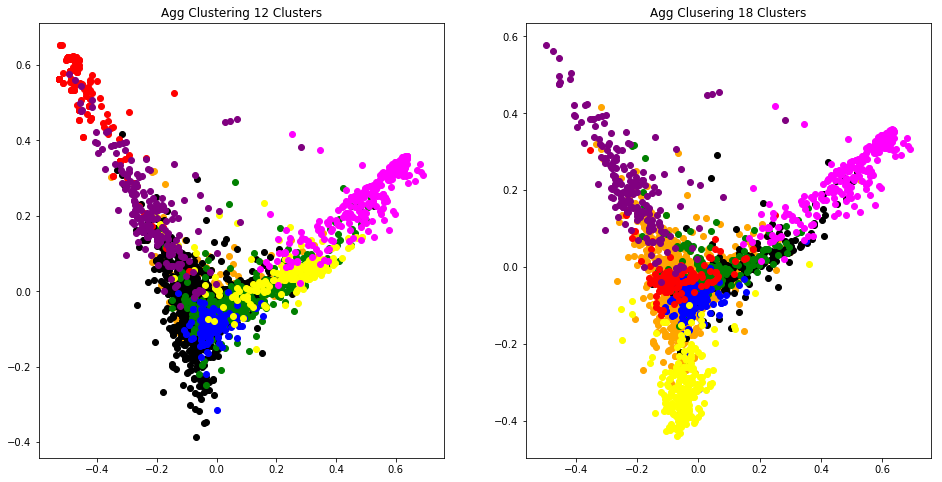

In [282]:
colors = ['orange', 'black', 'green', 'blue', 'yellow', 'red', 'purple', 'magenta']

fig, ax = plt.subplots(1,2, figsize=(16,8))
for cls, col in enumerate(colors[:16]):
    cls6 = PCAi[hcluster12 == cls]
    cls8 = PCAi[hcluster18 == cls]
    ax[0].scatter(cls6[:,0], cls6[:,1], color=col)
    ax[1].scatter(cls8[:,0], cls8[:,1], color=col)
ax[0].set_title("Agg Clustering 12 Clusters")
ax[1].set_title("Agg Clusering 18 Clusters")

In [283]:
fig.savefig("/Users/travis/Downloads/12_18_clusters_agg_mindf008_maxdf290_50feat")

# Cosine Similarity

In [291]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [292]:
get_cosine_sim(filings_for_kmeans[0],filings_for_kmeans[1])

array([[1.        , 0.97570822],
       [0.97570822, 1.        ]])

In [293]:
get_cosine_sim(filings_for_kmeans[0],filings_for_kmeans[2])[0][1]

0.0

In [294]:
print(len(file_names), len(filings_for_kmeans))
# print(file_names.index('.DS_Store'),file_names.index('cubesmart_10-Q'))

3739 3738


In [295]:
def find_real_index(file_name_index):
    if file_name_index <= 562:
        return file_name_index
    if file_name_index <= 1643:
        return file_name_index - 1
    else:
        return file_name_index - 2

So, if we're finding a filename > 562, subtract 1. > 1643, subtract 2.

In [296]:
def avg_cos(main_index,other_index,list_of_docs=filings_for_kmeans):
    global filings_for_kmeans
    cosine_sims = []
    for index in other_index:
        cosine_sims.append( get_cosine_sim(filings_for_kmeans[main_index],filings_for_kmeans[index])[0][1]  )
    
    return np.mean(cosine_sims)


def avg_cos_sim_from_file_names(main_file_name,other_file_name):
    global file_names
    main_index = find_real_index( file_names.index(main_file_name) )
    other_index = []
    for file_name in other_file_name:
        index = find_real_index( file_names.index( file_name) )
        other_index.append(index)
    
    return avg_cos(main_index,other_index)
    

In [297]:
avg_cos(0,[1,2,3,4,5])

0.6476446196474201

In [343]:
## Measure Similarity

GE = "generalelectricco_10-Q"
Similar_to_GE = ["entergycorpde_10-Q","sempraenergy_10-Q","chesapeakeutilitiescorp_10-Q",
                 "aescorp_10-Q","southernco_10-Q","mgeenergyinc_10-Q",
                "blackhillscorpsd_10-Q","pacificgas&electricco_10-Q"]

not_similar_to_ge = np.random.choice(file_names, size= 20) 

amzn = "amazoncominc_10-Q"
similar_to_amzn_retail = ["walmartinc._10-Q", "targetcorp_10-Q", "costcowholesalecorpnew_10-Q",
                         "bestbuycoinc_10-Q", "nordstrominc_10-Q", "jcpenneycoinc_10-Q"]

similar_to_amzn_tech = ["microsoftcorp_10-Q", "appleinc_10-Q", "alphabetinc._10-Q",
                       "netflixinc_10-Q"] 

not_similar_to_amzn = np.random.choice(file_names, size=len(similar_to_amzn_retail))

## GE

### Comparing 8 firms with SIC codes 4911 to GE.

In [344]:
avg_cos_sim_from_file_names(GE,Similar_to_GE)

0.7645343481478897

In [345]:
## Comparing GE to 30 randomly selected filings
avg_cos_sim_from_file_names(GE, not_similar_to_ge)

0.7383325816833295

In [346]:
# np.array(file_names) == 

In [347]:
#class # for GE
GE_index = find_real_index( file_names.index(GE) )
GE_culster = kmeans18[ GE_index ]
print("General Electric is in the ", "{}'th cluster".format(GE_culster))

General Electric is in the  13'th cluster


In [348]:
GE_class = kmeans18[ kmeans18 == GE_culster ]
num_companies = len(GE_class)
print("There are {} companies in the {}'th cluster, or {:.2f}% of the total"\
          .format(num_companies, GE_culster, num_companies / X.shape[0] * 100))

There are 819 companies in the 13'th cluster, or 21.91% of the total


In [349]:
import random
count = 0
y = random.sample( range(681), 8 )
z = []
for i in range(num_companies):
    if kmeans18[i] == GE_culster:
        if count in y:
            z.append(i)
        count = count + 1

## Comparing 8 firms within the same kmeans cluster as GE 

In [350]:
avg_cos(GE_index,z)

0.9575555535218524

In [351]:
pd.Series(kmeans18).value_counts() / kmeans18.shape[0] * 100

13    21.910112
17    10.781166
4      7.009096
3      5.858748
8      5.698234
2      5.510968
6      5.082932
14     5.056180
9      4.868914
1      4.868914
7      4.654896
15     3.718566
12     3.397539
16     2.782236
11     2.380952
10     2.354200
5      2.033173
0      2.033173
dtype: float64

In [394]:
GE_culster_h = hcluster18[ GE_index ]
GE_class_h = hcluster18[ hcluster18 == GE_culster_h ]
num_companies_h = len(GE_class_h)
print("GE is in the {}'th cluster".format(GE_culster_h))
print(num_companies_h)

GE is in the 0'th cluster
1372


In [395]:
# import random
count = 0
y = np.random.choice( range(cluster_size), 8 )
# z = np.random.choice(hcluster18[hcluster18 == GE_class_h], size=8)
z = []
for i in range(X.shape[0]):
    if hcluster18[i]== GE_culster_h:
        if count in y:
            z.append(i)
        count = count + 1

In [396]:
z

[653, 1084, 1594, 1662, 1734, 1746, 2240, 3173]

### Comparing 8 firms within the same Agg Clustering cluster as GE

In [397]:
avg_cos(GE_index,z)

0.7932852126555098

### Comparing 50 random firms to GE


In [398]:
z = random.sample( range(1642), 50)

In [399]:
avg_cos(amzn_index,z)

0.8485469582055962

## AMAZON

## Comparing 8 firms with Retail SIC codes to Amazon

In [405]:
avg_cos_sim_from_file_names(amzn, similar_to_amzn_retail)

0.8963280783144093

## Comparing 8 firms with Technology SIC codes to Amazon

In [406]:
avg_cos_sim_from_file_names(amzn, similar_to_amzn_tech)

0.8581109281103801

In [407]:
## Comparing AMZN to 30 randomly selected filings
avg_cos_sim_from_file_names(amzn, not_similar_to_amzn)

0.766967034947414

In [409]:
#class # for Amazon
amzn_index = find_real_index( file_names.index(amzn) )
amzn_culster = kmeans18[ amzn_index ]
print("Amazon is in the ", "{}'th cluster".format(amzn_culster))

Amazon is in the  6'th cluster


In [410]:
amzn_class = kmeans18[ kmeans18 == amzn_culster ]
num_companies = len(amzn_class)
print("There are {} companies in the {}'th cluster, or {:.2f}% of the total"\
          .format(num_companies, amzn_culster, num_companies / X.shape[0] * 100))

There are 190 companies in the 6'th cluster, or 5.08% of the total


In [415]:
count = 0
y = np.random.choice( range(cluster_size), 8 )
# z = np.random.choice(hcluster18[hcluster18 == GE_class_h], size=8)
z = []
for i in range(X.shape[0]):
    if kmeans18[i] == amzn_culster:
        if count in y:
            z.append(i)
        count = count + 1

### Comparing 8 firms within the same kmeans cluster as Amazon 

In [416]:
avg_cos(amzn_index,z)

0.9568494361151213

In [417]:
pd.Series(kmeans18).value_counts() / kmeans18.shape[0] * 100

13    21.910112
17    10.781166
4      7.009096
3      5.858748
8      5.698234
2      5.510968
6      5.082932
14     5.056180
9      4.868914
1      4.868914
7      4.654896
15     3.718566
12     3.397539
16     2.782236
11     2.380952
10     2.354200
5      2.033173
0      2.033173
dtype: float64

In [418]:
amzn_culster_h = hcluster18[ amzn_index ]
amzn_class_h = hcluster18[ hcluster18 == amzn_culster_h ]
num_companies_h = len(amzn_class_h)
print("Amazon is in the {}'th cluster".format(amzn_culster_h))
print(num_companies_h)

Amazon is in the 0'th cluster
1372


In [419]:
# import random
count = 0
y = np.random.choice( range(cluster_size), 8 )
z = []
for i in range(X.shape[0]):
    if hcluster18[i]== amzn_culster_h:
        if count in y:
            z.append(i)
        count = count + 1

In [420]:
z

[292, 342, 871, 991, 1777, 2014, 2063, 2083]

### Comparing 8 firms within the same Agg Clustering cluster as Amazon

In [421]:
avg_cos(amzn_index,z)

0.845389921859538

### Comparing 50 random firms to Amazon


In [422]:
z = random.sample( range(1642), 50)

In [423]:
avg_cos(amzn_index,z)

0.8268045146060348